## POTATO DISEASE CLASSIFICATION

#### IMPORTING THE NECESSARY LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers,models

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS = 10

In [3]:
dataset= keras.preprocessing.image_dataset_from_directory("C:\code\PlantVillage",seed=22,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                          batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
classes_name = dataset.class_names
classes_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0]


Here, as we can see the First element is a batch of 32 images of size 256x256 and 3 channels and Second element is a batch of 32 class labels.

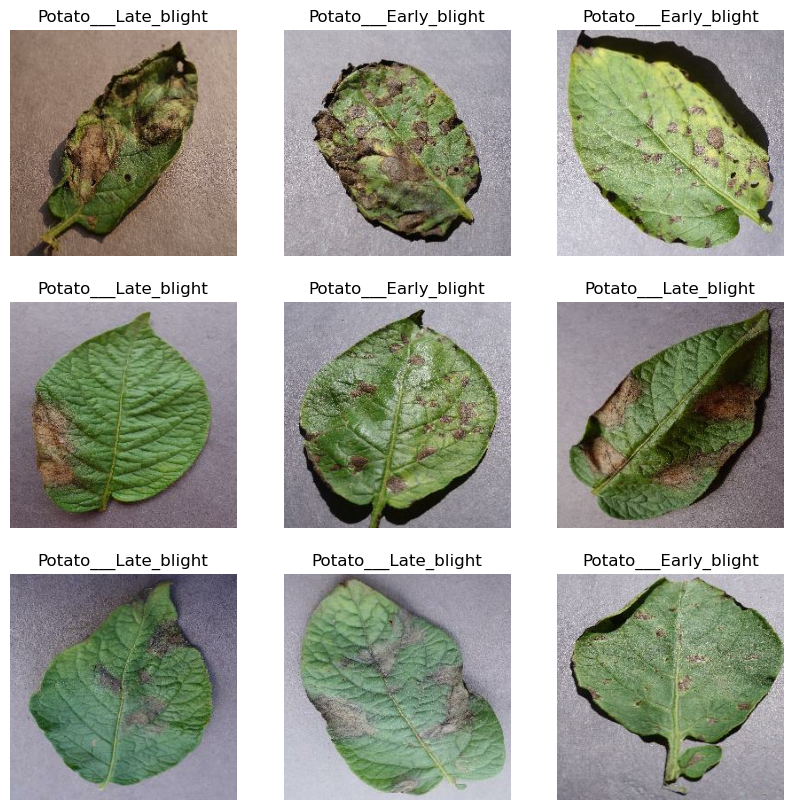

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes_name[label_batch[i].numpy()])
        plt.axis('off')

#### FUNCTION TO SPLIT THE DATASET

We will divide the dataset into 3 subsets namely training,validation and test dataset.

In [7]:
len(dataset)

68

In [8]:
32*68

2176

In [9]:
def get_dataset_partition(ds , train_split=0.8 , val_split=0.1 , test_split=0.1 , shuffle=True , shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    ds_size=len(dataset)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds = get_dataset_partition(dataset)

In [11]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

#### CACHE,SHUFFLE AND PREFETCH THE DATASET

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

#### BUILDING THE MODEL

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [23]:
resize_and_rescale = keras.Sequential([keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                       keras.layers.Rescaling(1./255,input_shape=(256,256,3))])

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [14]:
data_augmentation = keras.Sequential([keras.layers.RandomFlip("horizontal_and_vertical"),
                                      keras.layers.RandomRotation(0.2)])

Applying Data Augmentation to Train Dataset

In [15]:
#train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    keras.Input(shape=(256,256,3),batch_size=32),
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [38]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_84 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_85 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_86 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_87 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_88 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_89 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [40]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, verbose=1, epochs=10)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4493 - loss: 0.9315 - val_accuracy: 0.5521 - val_loss: 0.8145
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6215 - loss: 0.7405 - val_accuracy: 0.7865 - val_loss: 0.4980
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7709 - loss: 0.4909 - val_accuracy: 0.8750 - val_loss: 0.3232
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8461 - loss: 0.3589 - val_accuracy: 0.8021 - val_loss: 0.4958
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 982ms/step - accuracy: 0.8390 - loss: 0.3907 - val_accuracy: 0.9323 - val_loss: 0.2101
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 910ms/step - accuracy: 0.9069 - loss: 0.2091 - val_accuracy: 0.9323 - val_loss: 0.1687
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 873ms/step - accuracy: 0.9260 - loss: 0.1844 - val_accuracy: 0.9479 - val_loss: 0.1180
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 866ms/step - accuracy: 0.9382 - loss: 0.1539 - val_accuracy: 0.9896

In [41]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.9361 - loss: 0.1493


In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [45]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

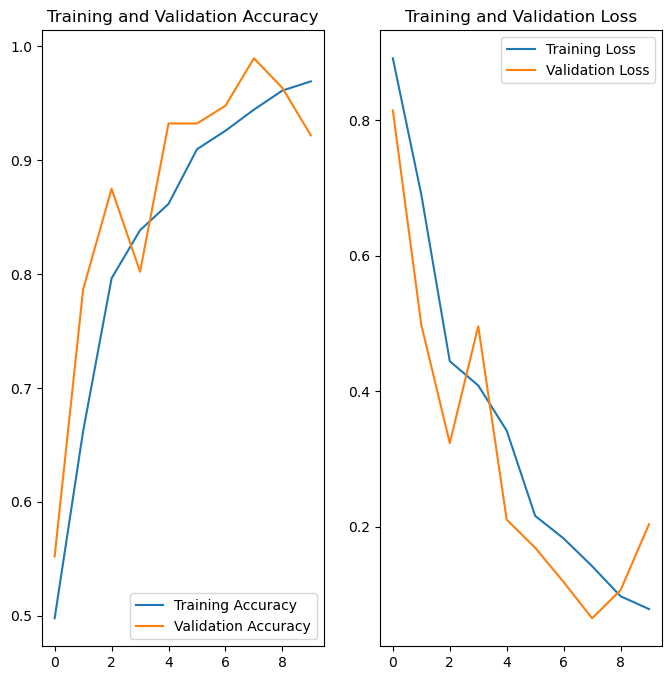

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
predicted label: Potato___Late_blight


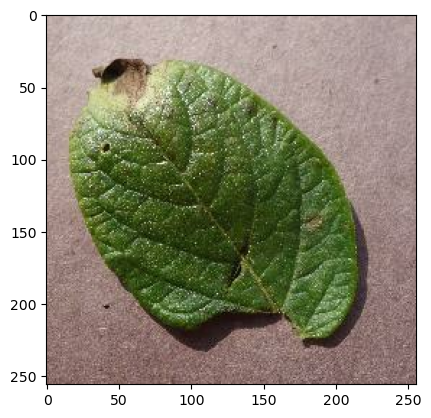

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes_name[np.argmax(batch_prediction[0])])

##### Write a function for inference.


In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

##### Now run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


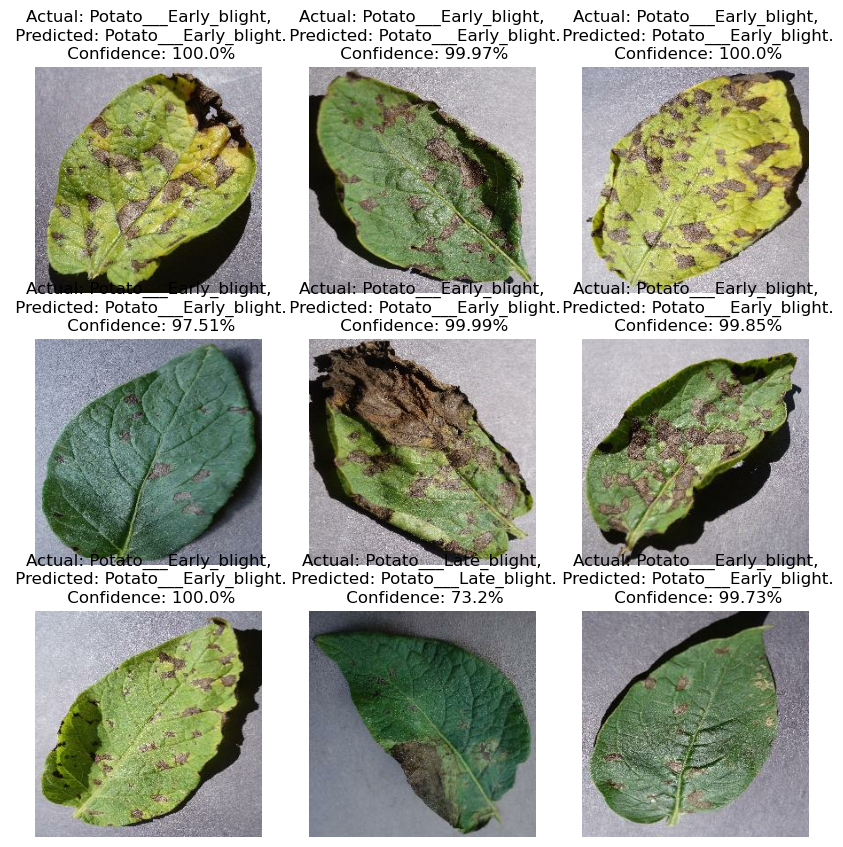

In [55]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [54]:
model.save('C:\code\PlantVillage\potato_model.h5')